In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

In [2]:
#Add All the Models Libraries

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

#regression
#Two new models added on June 28th 2018 - XGBOOST and LIGHTGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

In [3]:
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
train = pd.read_csv('D:\\Elo\\train.csv',parse_dates=["first_active_month"])
test = pd.read_csv('D:\\Elo\\test.csv', parse_dates=["first_active_month"])
merchants = pd.read_csv('D:\\Elo\\merchants.csv')

In [5]:
train.shape

(201917, 6)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


In [7]:
test.shape

(123623, 5)

In [8]:
merchants.shape

(334696, 22)

In [9]:
# Now extract the month, year, day, weekday
train["month"] = train["first_active_month"].dt.month
train["year"] = train["first_active_month"].dt.year
train['days'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days

test["month"] = train["first_active_month"].dt.month
test["year"] = train["first_active_month"].dt.year
test['days'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days

In [10]:
train = pd.get_dummies(train, columns=['feature_1', 'feature_2'])
test = pd.get_dummies(test, columns=['feature_1', 'feature_2'])

Now we will try to extract more features from Transactions Data

In [11]:
# Taking Reference from Other Kernels
def aggregate_transactions(trans, prefix):  
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [12]:
transactions = pd.read_csv('D:\\Elo\\historical_transactions.csv')
transactions = pd.get_dummies(transactions, columns=['category_2', 'category_3'])
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 1, 'N': 0})

In [13]:
import gc
merge_trans = aggregate_transactions(transactions, prefix='hist_')
del transactions
gc.collect()

train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
del merge_trans
gc.collect()


42

In [14]:
# Now extract the data from the new transactions
new_transactions = pd.read_csv('D:\\Elo\\new_merchant_transactions.csv')
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 1, 'N': 0})

In [15]:
merge_new = aggregate_transactions(new_transactions, prefix='new_')
del new_transactions
gc.collect()

train = pd.merge(train, merge_new, on='card_id',how='left')
test = pd.merge(test, merge_new, on='card_id',how='left')
del merge_new

gc.collect()

35

In [16]:
# Now check the shape of Train and Test Data
train.shape

(201917, 67)

In [17]:
test.shape

(123623, 66)

In [18]:
train = train.drop(['card_id','first_active_month'], axis=1)
test = test.drop(['card_id','first_active_month'], axis=1)

In [19]:
categoryVariableList = ['month','year']
for var in categoryVariableList:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [20]:
# Get the correlation matrix for the training set

train_y = train.target.reset_index(drop=True)
train_x = train.drop(['target'], axis=1)
test_x = test

Imputations and Data Transformation

In [21]:
columns = [ 'hist_transactions_count',
            'hist_authorized_flag_sum',
            'hist_authorized_flag_mean',
            'hist_category_1_mean',
            'hist_category_2_1.0_mean',
            'hist_category_2_2.0_mean',
            'hist_category_2_3.0_mean',
            'hist_category_2_4.0_mean',
            'hist_category_2_5.0_mean',
            'hist_category_3_A_mean',
            'hist_category_3_B_mean',
            'hist_category_3_C_mean',
            'hist_merchant_id_nunique',
            'hist_purchase_amount_sum',
            'hist_purchase_amount_mean',
            'hist_purchase_amount_max',
            'hist_purchase_amount_min',
            'hist_purchase_amount_std',
            'hist_installments_sum',
            'hist_installments_mean',
            'hist_installments_max',
            'hist_installments_min',
            'hist_installments_std',
            'hist_purchase_date_ptp',
            'hist_month_lag_min',
            'hist_month_lag_max',
            'new_transactions_count',
            'new_authorized_flag_sum',
            'new_authorized_flag_mean',
            'new_category_1_mean',
            'new_category_2_1.0_mean',
            'new_category_2_2.0_mean',
            'new_category_2_3.0_mean',
            'new_category_2_4.0_mean',
            'new_category_2_5.0_mean',
            'new_category_3_A_mean',
            'new_category_3_B_mean',
            'new_category_3_C_mean',
            'new_merchant_id_nunique',
            'new_purchase_amount_sum',
            'new_purchase_amount_mean',
            'new_purchase_amount_max',
            'new_purchase_amount_min',
            'new_purchase_amount_std',
            'new_installments_sum',
            'new_installments_mean',
            'new_installments_max',
            'new_installments_min',
            'new_installments_std',
            'new_purchase_date_ptp',
            'new_month_lag_min',
            'new_month_lag_max',
            'days'
]

for col in columns:
    train_x.update(train_x[col].fillna(0, inplace=True))
    test_x.update(test_x[col].fillna(0, inplace=True))

In [22]:
#Check for missing values in training set
nulls = np.sum(train_x.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = train_x.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values in training set")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values in training set


In [23]:
#Check for missing values in test set
nulls = np.sum(test_x.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = test_x.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values in test set")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values in test set


PCA Analysis

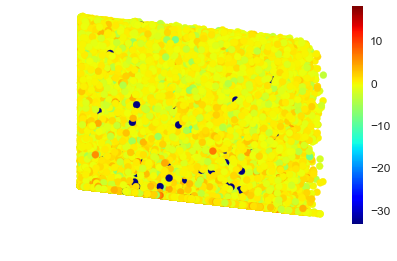

In [24]:
from sklearn.decomposition import PCA

PCA_train_x = PCA(n_components=64, random_state=42).fit_transform(train_x)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=train_y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

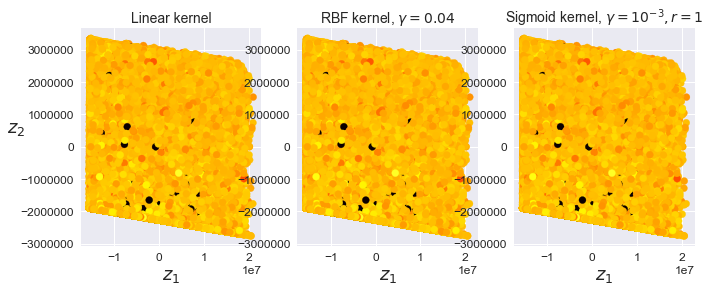

In [25]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 64, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 64, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 64, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=train_y, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Apply Standard Scaler on Non Categorical Features

In [26]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [27]:
num_pipeline = Pipeline([
        ("selector", DataFrameSelector(columns)),
        ('std_scaler', StandardScaler()),
      ])

no_pipeline = Pipeline([
        ("selector", DataFrameSelector(categoryVariableList))
    ])

In [28]:
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("no_pipeline", no_pipeline),
    ])

final_train_X = full_pipeline.fit_transform(train_x)
final_test_X = full_pipeline.transform(test_x)

In [29]:
#LIGHT GBM REGRESSOR

light_gbm = LGBMRegressor(random_state = 42)

light_gbm.fit(final_train_X, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=42,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [30]:
y_pred_rf= light_gbm.predict(final_train_X)
rf_msle = mean_squared_error(train_y, y_pred_rf)
rf_rmsle = np.sqrt(rf_msle)
rf_rmsle

3.4942725352625965

In [31]:
#LIGHT GBM REGRESSOR

light_gbm = LGBMRegressor(random_state = 42)

n_estimators = [50,100,200]
num_leaves = [50,100,200]
learning_rate = [0.005,0.05]

param_grid_LightGBM = {'n_estimators' : n_estimators, 'learning_rate' : learning_rate, 'num_leaves':num_leaves}


rand_search_LightGBM = RandomizedSearchCV(light_gbm, param_grid_LightGBM, cv = 4, scoring='neg_mean_squared_error', 
                               refit = True, n_jobs = -1, verbose = 2)

rand_search_LightGBM.fit(final_train_X, train_y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 17.1min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=42,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 200], 'learning_rate': [0.005, 0.05], 'num_leaves': [50, 100, 200]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [32]:
lgbm_estimator = rand_search_LightGBM.best_estimator_ 
y_pred_lgbm = lgbm_estimator.predict(final_train_X)
lgbm_msle = mean_squared_error(train_y, y_pred_lgbm)
lgbm_rmsle = np.sqrt(lgbm_msle)
lgbm_rmsle

3.3803926476069144

In [33]:
#XGB REGRESSOR

xgb_reg = XGBRegressor(random_state = 42)

grid_search_xgb = GridSearchCV(xgb_reg, param_grid_xgb, cv = 4, scoring='neg_mean_squared_error', 
                               refit = True, n_jobs = -1, verbose = 2)

grid_search_xgb.fit(final_train_X, train_y)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 20.0min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.005, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [34]:
xgb_estimator = grid_search_xgb.best_estimator_ 
y_pred_xgb = xgb_estimator.predict(final_train_X)
xgb_msle = mean_squared_error(train_y, y_pred_xgb)
xgb_rmsle = np.sqrt(xgb_msle)
xgb_rmsle

3.722928121284016

RMSE on Test Data

In [40]:
y_pred_xgb_te = xgb_estimator.predict(final_test_X)
sample_submission = pd.read_csv('D:\\Elo\\sample_submission.csv')
sample_submission['target'] = y_pred_xgb_te
sample_submission.to_csv('submission_ashish.csv', index=False)

In [41]:
y_pred_lgbm_te = lgbm_estimator.predict(final_test_X)
sample_submission = pd.read_csv('D:\\Elo\\sample_submission.csv')
sample_submission['target'] = y_pred_lgbm_te
sample_submission.to_csv('submission_ashish_lgbm.csv', index=False)